<a href="https://colab.research.google.com/github/okojoalg/catalyst-for-beginner/blob/main/01_MNIST_FCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#【Catalyst/PyTorch入門(1)】MNISTを全結合ニューラルネットワークで学習させてみる　

PyTorchのフレームワークの1つであるCatalystを使用して、MNISTを全結合ニューラルネットワークで学習します。

**読者前提** :
* Catalyst(PyTorch)を使用したことがない方
* 深層学習については入門以上の知識があり、Kerasなどの深層学習フレームワークを触った経験がある方


## インストール

Google Colabにはインストールされていないライブラリをインストールします。
プリインストールされているライブラリは将来的にversionが変わる可能性があります。
執筆時点での主要なライブラリのversionを以下に記載します。

* **torch**: 1.7.0+cu101
* **torchvision**: 0.8.1+cu101
* **catalyst**: 20.12
* **torchviz**: 0.0.1



In [ ]:
!pip install catalyst==20.12 torchviz==0.0.1

     |████████████████████████████████| 491kB 8.3MB/s 
     |████████████████████████████████| 51kB 8.3MB/s 
     |████████████████████████████████| 317kB 13.9MB/s 
  Created wheel for torchviz: filename=torchviz-0.0.1-cp36-none-any.whl size=3522 sha256=7b77bfcf34ba375bddea12df2ee2c19250730c0a119c91fabfddf3044c86e64c
  Stored in directory: /root/.cache/pip/wheels/2a/c2/c5/b8b4d0f7992c735f6db5bfa3c5f354cf36502037ca2b585667
Successfully built torchviz


## import

必要なライブラリをimportしておきます。
torch.nnはPyTorchでモデルなどを定義するときに必要なクラスを多く含んでいます。慣習に従ってnnの名でimportします。

他のクラス・メソッドについては使用時に説明します。

In [ ]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST
from torchvision.transforms import transforms
from catalyst.dl import SupervisedRunner
from catalyst.dl.callbacks import AccuracyCallback
from catalyst.utils import get_device
from torchviz import make_dot

## ハイパーパラメータ

In [ ]:
# class数
num_class = 10
# 学習のepoch数
epochs = 30
# モデルやログファイルなどの保存先
logdir = "output/"
# random seed
seed = 1988
# バッチサイズ
batch_size=128
# データローダに使用するプロセス数
num_workers=2

## モデル設計

モデルは隠れ層が1つのシンプルな全結合ネットワークとして定義します。各ユニットの数は以下のとおりです。

* **入力ユニット**: 784
* **隠れユニット**: 2048
* **出力ユニット**: 10

入力・出力ユニットはそれぞれ、MNISTの入力次元、分類数にあわせていますが、隠れユニット数は変更可能です。

また、計算グラフを可視化してみます。

In [ ]:
in_unit, hidden_unit, out_unit = 784, 2048, 10

model = nn.Sequential(*[
    nn.Linear(in_features=in_unit, out_features=hidden_unit),
    nn.ReLU(),
    nn.Linear(in_features=hidden_unit, out_features=out_unit),
    nn.Softmax(dim=1)
])

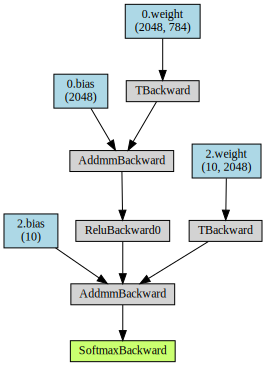

In [ ]:
x = torch.zeros(1, 784, dtype=torch.float, requires_grad=False)
model.eval()
y = model(x)
make_dot(y, params=dict(model.named_parameters()))

## データローダの定義

### Reshape変換の定義

torchvisionのMNISTの画像データは(channel=3, height=28, width=28)のテンソルで呼び出されます。今回は畳み込み層ではなく全結合層へ入力するため、reshapeして(784,)のテンソルにする必要があります。前処理で手軽にshapeの変換ができるようにReshapeクラスを定義します。

In [ ]:
class Reshape:
    def __init__(self, size=-1):
        self.size = size

    def __call__(self, image):
        return image.view(self.size)

### 前処理

データセットから呼び出すときに実施する前処理を記載します。
ToTensor()はPILなどで読み出された画像をテンソルに変換します。その際に[0, 1]の範囲に変換されることに注意してください。

このままでもよいのですが、Normalize()で平均・分散が0.5を指定して正規化をしています。

最後に上で定義したReshape()を使用して(784,)のテンソルに変換しています。

In [ ]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
        Reshape(),
     ])

### データセットの準備

MNISTのデータセットを準備します。torchvisionで用意されているクラスがあるので、難しいことはありません。

引数にdownload=Trueを与えるだけでダウンロードも実施します。

transformに先程定義したtransformのオブジェクトを与えることで、データロードと同時に、予め定義した前処理が実施されます。

In [ ]:
train_dataset = MNIST(
    root='./data', # データ保存先
    train=True, # trainデータセットの場合はTrue, testデータセットの場合はFalseを指定する
    download=True,
    transform=transform
)

val_dataset = MNIST(
    root='./test',
    train=False,
    download=True,
    transform=transform
)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!




/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning:

The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)



Extracting ./test/MNIST/raw/train-images-idx3-ubyte.gz to ./test/MNIST/raw


Extracting ./test/MNIST/raw/train-labels-idx1-ubyte.gz to ./test/MNIST/raw


Extracting ./test/MNIST/raw/t10k-images-idx3-ubyte.gz to ./test/MNIST/raw


Extracting ./test/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./test/MNIST/raw
Processing...
Done!


### データローダの定義

データローダはデータセットのデータをミニバッチにして読み込むときに使用します。
**データローダは辞書にする必要があるため、注意しましょう。**key: 'train'に学習用のデータローダ、key: 'valid'に検証用のデータローダを設定します。変えることもできるのですが、デフォルトの設定に合わせています。
事前に定義しているバッチサイズ、ロード時に使用するプロセス数などを与えます。引数shuffleはシャッフルするか規定の順番で呼び出すか選べますが、検証データセットはシャッフルしてもしなくても変わらないためFalseに設定しています。

In [ ]:
dataloaders = {
    'train': DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers
    ),
    'valid': DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers
    ),
}

## その他オブジェクトの設定

criterionには損失関数として、クロスエントロピーを、optimizerにはAdamを、よくあるハイパーパラメータで設定しています。

schedulerは10epochsごとに学習率が1/10になるように設定しました。

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-7, weight_decay=1e-5)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

## Catalystの登場!!

これまではPyTorchだけで済む話だったのですが、ここでようやくCatalystが登場します。catalyst.dl.SupervisedRunnerクラスを使用することで、学習コードを書く必要がなくなります。カスタマイズしたい場合はcatalyst.dl.Runnerをオーバーライドすればよいのですが、次回以降に記載します。

get_device()ではGoogle ColabのGPUデバイスオブジェクトを取得しています。

In [ ]:
runner = SupervisedRunner(device=get_device())

## 学習

定義したrunnerを使って学習します。基本は今まで定義したものを渡すだけでよいです。

valid_loaderには'valid'を与えていますが、辞書dataloadersの検証用データセットを示すkeyを与えればよいです。defaultは'valid'なので指定不要ですが、学習のため記載しました。

callbacksにはAccuracyCallbackを与えています。accuracy_argsを整数nのリストを指定して渡すことで、正解が推論結果のn位以内に含まれている割合を計算します。ここでは[1, 5]を指定しているため、通常の意味の正解率(accuracy01)と、推論結果の5位以内に含まれている割合(accuracy05)がメトリックとして追加されます。

main_metricには監視するメトリックを指定します。このメトリックが最善のモデルは保存されます。

minimize_metricはクロスエントロピーのように小さいほどよいような指標の場合はTrueを、正解率のように大きいほどよいような指標の場合はFalseを設定します。

load_best_on_endをTrueに設定すると、学習後に最善の重みをrunnerにロードします。

In [ ]:
runner.train(
        model=model,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        loaders=dataloaders,
        valid_loader="valid", # default
        logdir=logdir,
        callbacks=[AccuracyCallback(num_classes=num_class, accuracy_args=[1, 5])],
        num_epochs=epochs,
        main_metric="loss", # default
        minimize_metric=True, # default
        initial_seed=seed,
        verbose=False,
        load_best_on_end=True,
)






[2021-02-05 14:52:11,106] 
1/30 * Epoch 1 (_base): lr=0.0010 | momentum=0.9000
1/30 * Epoch 1 (train): accuracy01=0.7951 | accuracy05=0.8956 | loss=1.6709
1/30 * Epoch 1 (valid): accuracy01=0.9375 | accuracy05=0.9958 | loss=1.5274
[2021-02-05 14:52:23,083] 
2/30 * Epoch 2 (_base): lr=0.0010 | momentum=0.9000
2/30 * Epoch 2 (train): accuracy01=0.9403 | accuracy05=0.9963 | loss=1.5242
2/30 * Epoch 2 (valid): accuracy01=0.9497 | accuracy05=0.9974 | loss=1.5146
[2021-02-05 14:52:34,822] 
3/30 * Epoch 3 (_base): lr=0.0010 | momentum=0.9000
3/30 * Epoch 3 (train): accuracy01=0.9535 | accuracy05=0.9971 | loss=1.5098
3/30 * Epoch 3 (valid): accuracy01=0.9574 | accuracy05=0.9977 | loss=1.5054
[2021-02-05 14:52:46,634] 
4/30 * Epoch 4 (_base): lr=0.0010 | momentum=0.9000
4/30 * Epoch 4 (train): accuracy01=0.9602 | accuracy05=0.9979 | loss=1.5028
4/30 * Epoch 4 (valid): accuracy01=0.9562 | accuracy05=0.9972 | loss=1.5062
[2021-02-05 14:52:58,365] 
5/30 * Epoch 5 (_base): lr=0.0010 | momentum

## 推論

validのデータローダがら読み出して、試しに推論し、結果を表示してみましょう。predict_loader()メソッドにデータローダを与えると推論ができます。SupervisedRunner()を使用した場合、推論結果は辞書で返り、'logits'のkeyで参照ができます。以下では、その結果を10個だけ取り出しました。

In [ ]:
predictions = next(runner.predict_loader(loader=dataloaders["valid"]))
for i, prediction in enumerate(predictions["logits"]):
    prediction = prediction.detach().cpu()
    key = torch.argmax(prediction).item()
    print(f"推論結果: {key}, 確信度: {prediction[key]:.3f}")
    if i > 10:
        break

推論結果: 7, 確信度: 1.000
推論結果: 2, 確信度: 1.000
推論結果: 1, 確信度: 1.000
推論結果: 0, 確信度: 1.000
推論結果: 4, 確信度: 1.000
推論結果: 1, 確信度: 1.000
推論結果: 4, 確信度: 1.000
推論結果: 9, 確信度: 1.000
推論結果: 6, 確信度: 0.598
推論結果: 9, 確信度: 1.000
推論結果: 0, 確信度: 1.000
推論結果: 6, 確信度: 1.000
